$
\DeclareMathOperator*{\P}{\operatorname{P}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\xv}{\mathbf{x}}
\newcommand{\E}{\mathbb{E}}
$

<h1><center><br/>Generative Adversarial Networks</center></h1>

<font size="3">
    <center>
        Jason D. Stock
        <br/>
        <br/>
        <i>Introduction to Machine Learning</i>
        <br/>
        <i>April 16<sup>th</sup>, 2019</i>
    </center>
</font>

# Table of Contents

* [Overview](#Overview)
* [Random Variables](#Random-Variables)
* [Neural Networks](#Neural-Networks)
    * [Inception Score Evaluation](#Inception-Score-Evaluation)
    * [Inception Score Implementation](#Inception-Score-Implementation)
    * [Generative Adversarial Network Implementation](#Generative-Adversarial-Network-Implementation)
* [Conclusion](#Conclusion)

# Overview  

There is a recent application of Machine Learning known as Generative Adversarial Networks (GANs), which was introduced by [Ian J. Goodfellow](https://arxiv.org/abs/1406.2661) in 2014. These types of networks belong in the set of generative models which can be used to generate / produce new data. For this notebook, I will explore the structure and training process of GANs by producing "hand-written" digits from a neural network that appear similar to those in the MNIST dataset.

Some more preliminary details, background, interests, etc... 

In [1]:
import torch
from torch import nn, optim
from torch.utils import data
from torch.autograd.variable import Variable

import torchvision
import torchvision.transforms as transforms

import math
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from ipywidgets import FloatProgress
from IPython.display import display

rc('animation', html='jshtml');

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
class options():
    def __init__(self):
        # dimensionality of the latent space
        self.latent_dim = 100
        
        # batch size
        self.batch_size = 64

        # number of image channels
        self.n_channels = 1

        # size of each image dimension
        self.img_size = 28
        
        # number of training epochs
        self.n_epochs = 35
        
        # learning rate for backprop
        self.lr = 2e-3
        
        # Adam beta 1 parameter
        self.beta_1 = 0.50
        
        # Adam beta 2 parameter
        self.beta_2 = 0.999
        
opt = options()
img_shape = (opt.n_channels, opt.img_size, opt.img_size)

Read in the data ...

Data can be normalized for each channel (there is only one for the MNIST data) by computing forcing the values in the range $[-1, 1]$. This is done by specifying a standard deviation of $\sigma = 0.5$, and computing the new intensity $I^{\prime} = (I - \mu)\;/\;\sigma$.

In [3]:
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.Resize(opt.img_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                                  ]))
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.Resize(opt.img_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                                  ]))

data_loader = torch.utils.data.DataLoader(train_data, batch_size=opt.batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=opt.batch_size,
                                          shuffle=True)

Show some examples ...

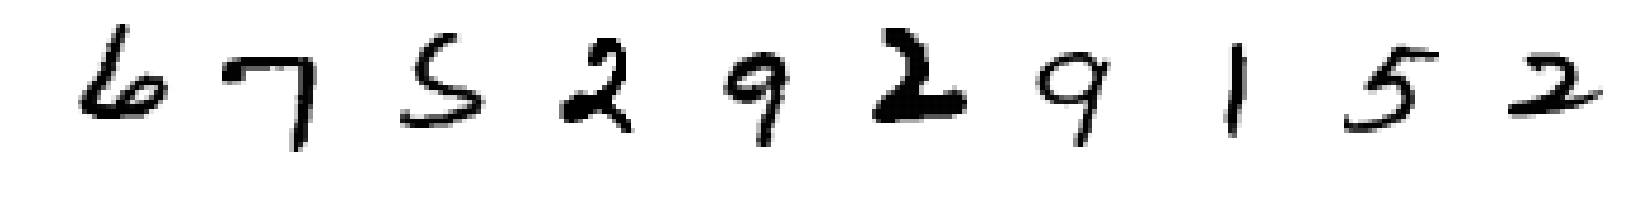

In [4]:
dataiter = iter(data_loader)
imgs, labels = dataiter.next()

def imshow(imgs, n_imgs=None):
    items = n_imgs
    cols = 10
    if n_imgs is None :
        items = imgs.shape[0]
        rows = int(items / 8) + 1 if items > 10 else 1
        fig = (14, 10)
    else:
        rows = int(n_imgs / 10) + 1 if n_imgs > 10 else 1
        fig = (14, rows)

    plt.figure(figsize=fig)
    for i in range(items):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(-imgs[i, :].reshape((28, 28)), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.show();

imshow(imgs[:10, ...])

In [5]:
def images_to_vectors(images):
    return images.view(images.size(0), -1)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), opt.n_channels, opt.img_size, opt.img_size)

print('Vector shape: {}'.format(images_to_vectors(imgs[:1, ...]).shape))

Vector shape: torch.Size([1, 784])


Suppose a single image of the number *nine*, which is represented as a square $ n\times n$ matrix, is flattened to a $1\times n^2$ vector.  If this vector was reshaped to its original dimensions it would obviously represent a *nine* again. However, there exists an infinite number of images that take this same shape, and do not take the qualities of a *nine*.  Therefore, it can be inferred that the $1\times n^2$ vectors that do represent a *nine* fit a very specific probability distribution over the entire vector space.

The problem of generating an image of a *nine* can now be interpreted as finding the probability distribution over the $1\times n^2$ vector space. This can be accomplished by taking a random variable from this very specific and highly complex probability distribution space. However, it becomes nearly impossible to directly express this distribution. There are, however, probability distributions that we can sample from that are well represented. Let's leverage those that are defined to accomplish the problem.  

# Random Variables  


A continuous random variable $U$ has the probability density of a uniform distribution, denoted $U \sim \mathcal{U}[a, b]$, if the probability density function (PDF) is,

$$
f_U(u)=
\begin{cases}
  \frac{1}{b-a} & \text{if}\ u \in [a, b] \\
  0 & \text{otherwise}
\end{cases}
$$

The cumulative distribution function (CDF) of a random variable $U$, evaluated at $u$, is the probability that $U$ will take a probability less than or equal to $u$ [\[1\]](https://en.wikipedia.org/wiki/Uniform_distribution). This can be directly solved for by integrating the PDF over the interval $0$ to $u$. Let's represent the CDF of a standard uniform random variable on the support of $U$ as,

$$
F_U(u)=
\operatorname{P}(U\leq u) = \int_0^u \! f_U(t) \, \mathrm{d}t = u \quad \forall u \in [0,1]
$$

The standard uniform probability density function and the respective cumulative distribution functions on the interval from $0$ to $1$ are shown below.

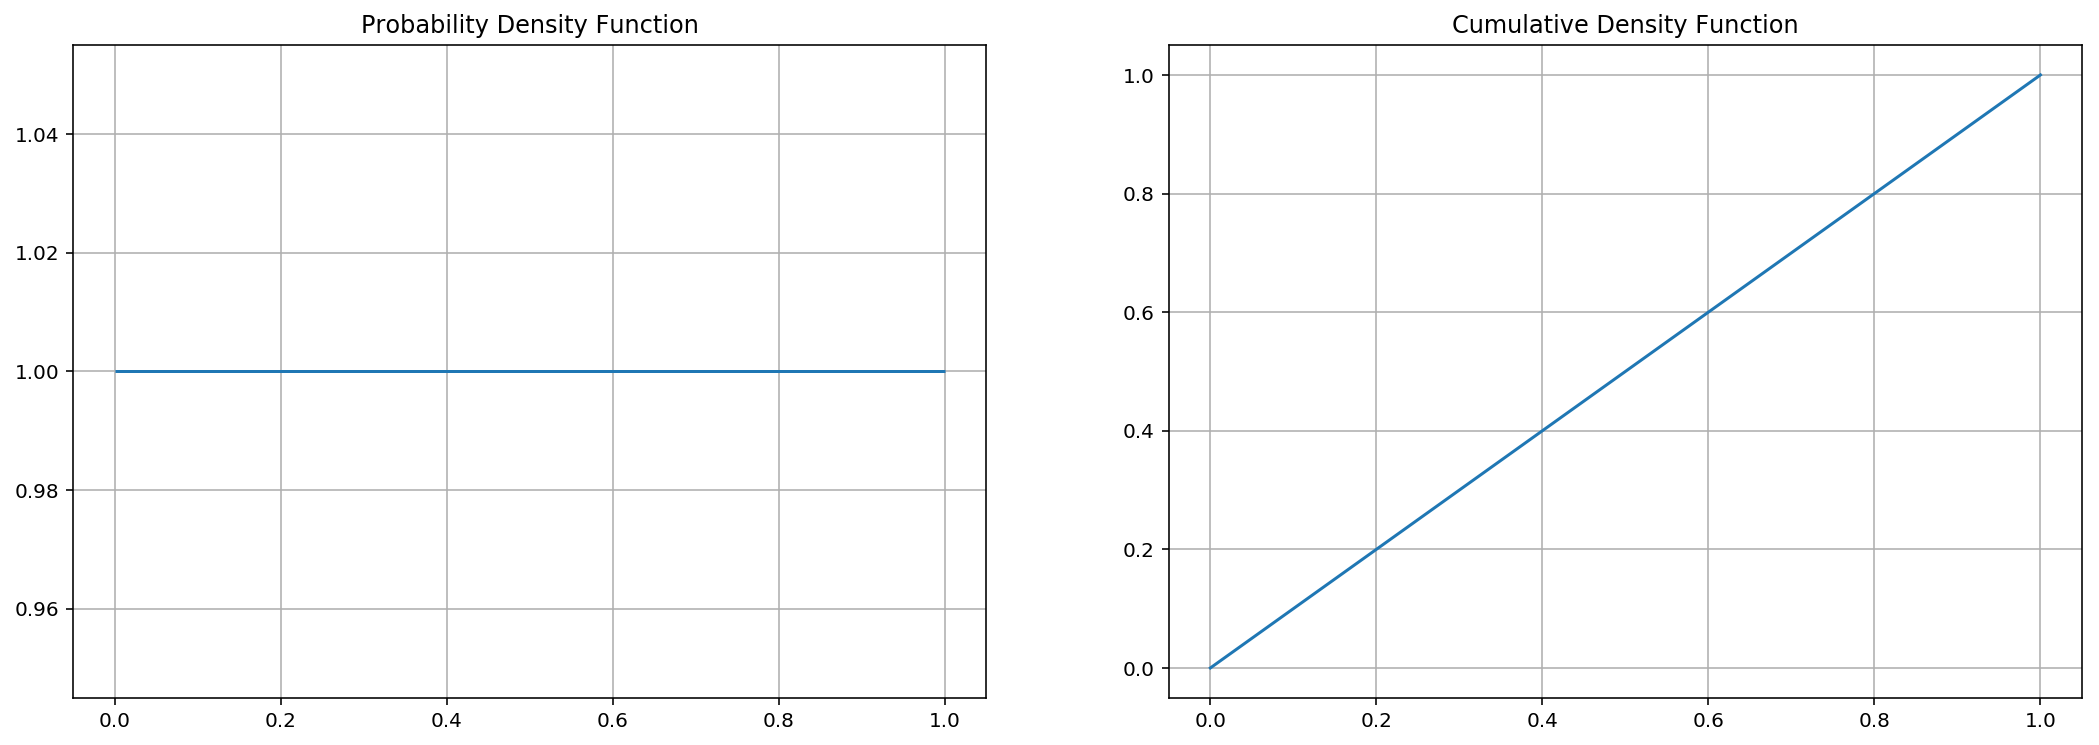

In [6]:
a, b = 0, 1

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1); plt.hlines(1/(b-a), a, b, 'tab:blue')
plt.title('Probability Density Function'); plt.grid(True)

plt.subplot(1, 2, 2); plt.plot([0, 1])
plt.title('Cumulative Density Function'); plt.grid(True);

We know how to sample from $U$ fairly easily, so how can we use this to sample from another distribution? Such as the complex distribution that represented a *nine*.  We can define $X$ as a random variable with the CDF as $F_X(x)=\P(X \leq x)$. If $F_X$ is strictly increasing, then $F_X(x) = u$ is unique for each $0 < u < 1 $, denoted by $x = F_X^{-1}(u)$. Therefore, 

$$
F_X(x)=
\P(U \leq F_X(x)) = \P(F_X^{-1}(U) \leq x)
$$

This indicates that if $u_0, u_1, \dots, u_n$ are sampled from a uniform distribution, and $x_i$ is the solution to $F_X(x) = u_i$, then $x_0, x_1, \dots, x_n$ are sampled from a distribution $F_X$ [\[2\]](http://www3.eng.cam.ac.uk/~ss248/G12-M01/Week1/ITM.pdf). A generalization for this defines the random variable $Y = F_X^{-1}(U)$ as having the same CDF as $X$. In other words, we are able to obtain a value from a target distribution from passing a value from a uniform distribution through the inverse transform function. However, defining the transform function is not simply expressible, and is something that has to be learned. Perhaps we could train a neural network to learn said transform function.

# Neural Networks  

There are two prominent models in machine learning: discriminative models and generative models. Each are used in a specific use case due to their differences in underlying probability inferences. A discriminative model is most commonly used in classification, since the underlying model is trained to find the conditional probability $\P(Y \;|\; X=x)$; that is, given some sample $x$, what is the probability of class $Y$? A simple logistic regression model can be used to find the parameters that minimize the squared error, which inherently creates boundaries between the classes, and can deterministically classify a sample.  

A generative model estimate the joint probability $\P(X \:,\: Y) = \P(X \;|\; Y)\P(Y)$; that is, given a hidden representation of $Y$, we can find the associated features for $X$. Thus, a generative model is trained to represent the distribution for each class. We would like to use this generative model in our approach to generate features of a complex distribution given samples taken from a uniform distribution.

To accomplish this we will experiment with a subclass of generative models known as Generative Adversarial Networks (GAN). This was an idea that was formally introduced in 2014 with a paper by Ian J. Goodfellow *et al.* [\[3\]](https://arxiv.org/pdf/1406.2661.pdf). The concept defines two neural networks, a generator model $G$ that attempts to provide samples similar to the expected data, and a discriminator $D$ that tries to resolve fake images from real ones. Both of these networks coexist as to be adversaries towards one another while continuously improving. The adversary $G$ will train to produce images that fool the discriminator, while $D$ attempts to gets better at catching fake images.  

The generator $G$ takes as input a random variable $z$ which has the probability density from distribution $p_z$ - say, a uniform distribution. The output of $G(z) = x_g$ which implicitly defines $p_g$ as the probability density of samples $G(z)$ taken from $z \sim p_z$ [\[3\]](https://arxiv.org/pdf/1406.2661.pdf). The discriminative network $D$ takes an input a real value $x_t$ from the density $p_t$, *or* a generated value $x_g$. The output of $D(x)$ is a value between $0$ and $1$ representing the probability of a real or fake sample. Thus, updates to the discriminators weights $\wv_D$ can be made to maximize the probability of correctly labeling data from $p_t$ and samples from $p_g$, i.e., maximizing $D(x_t)$ while minimizing $D(G(z))$. Simultaneously, the generators weights $\wv_G$ are updated by maximizing the probability that $x_g$ belongs to the target distribution $p_t$, i.e., maximizing the outcome of $D(G(z))$.

The discriminator and generator are trained to optimize opposite loss functions, which is expressible as a minimax game with a real valued function $V(D,G)$:

$$
\begin{aligned}
\min_G \max_D V(D, G) 
    & = \E_{x \sim p_t(x)} \big[\log D(x)\big] + \E_{z \sim p_z(z)} \big[\log(1 - D(G(z)))\big] \\
    & = \E_{x \sim p_t(x)} \big[\log D(x)\big] + \E_{x \sim p_g(x)} \big[\log(1 - D(x)\big]
\end{aligned}
$$

Breaking this down, the term $\E_{x \sim p_t(x)} \big[\log D(x)\big]$ denotes the log probability of $D$ predicting the real value samples from the density $p_t$ are authentic. Whereas, $\E_{x \sim p_g(x)} \big[\log(1 - D(x)\big]$ denotes the log probability of $D$ predicting samples from $p_g$ as not genuine [\[4\]](https://www.cs.toronto.edu/~duvenaud/courses/csc2541/slides/gan-foundations.pdf).  

## Inception Score Evaluation

Measuring the accuracy, or quality, of our generative network can be challenging. This network produces images that are *supposed* to fall in the same distribution from our training samples, $p_t$. Therefore, a random variable from a uniform distribution will be mapped to a target value. So, how can we measure this value as "accurate"?

A metric known as the Inception Score (IS) was introduced by Salimans *et al.* [\[5\]](https://arxiv.org/pdf/1606.03498.pdf) to best attempt at correlating with human judgement. The IS uses the Inception v3 pretrained network to compute a statistic of the networks output from the generated images $\xv = G(\zv)$,

$$
\text{IS}(G) = \exp \big[\:\E_{\xv \sim p_g}D_{KL} (\:p(y\:|\:\xv) \parallel p(y)\:)\:\big]
$$

where $\xv \sim p_g$ denotes the vector of images sampled from the density $p_g$. The Kullback-Leibler (KL) Divergence [\[6\]](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence), $D_{KL}(P \parallel Q)$, can be used to measure the similarity / differences between two probability distributions $P$ and $Q$, where $P = p(y\:|\:\xv)$, and $Q = p(y) = \int_x  p(y\:|\:\xv)p_g(\xv)$.  

The conditional label distribution, $p(y\:|\:\xv)$, represents the probabilities for class $y$ given $\xv$. A conditional probability with low entropy will indicate images with more identifiable details. Furthermore, we can compute the marginal label distribution $p(y)$ to measure how much variety there is in $p_g$, where higher entropy represents more variety. Let's define an empirical marginal distribution as $ \tilde{p\,}(y) = \frac{1}{N}\sum_{i=1}^{N}p(y\:|\:\xv_i)$.  

We can compute the conditional label probabilities for each class $k$ using the softmax function to map a value betwen $0$ and $1$ which sums the probabilities for all classes $K$ to $1$ [\[7\]](https://nbviewer.jupyter.org/url/www.cs.colostate.edu/~anderson/cs445/notebooks/14%20Classification%20with%20Linear%20Logistic%20Regression.ipynb). The probability of $\xv$ belonging to a specific class $k$ can then be calculated as,

$$
p(C=k\:|\:\xv) = \frac{p(\xv\:|\:C=k)\,p(C=k)}{\sum_{m=1}^{K}p(\xv\:|\:C=m)\,p(C=m)} = \frac{e^{\,a_k}}{\sum_{m=1}^{K}e^{\,a_m}}
$$

Therefore, we can use an auxiliary neural network trained to maximize the data likelihood for each class. As previously mentioned, the original IS uses the Inception v3 network to better measure derive a metric. However, for this experiment, we will train a convolutional neural network (CNN) on known MNIST samples to calculate the conditional and marginal distributions.  

Once the distributions are calculated, the KL Divergence can be computed. This value is high when the two distributions are dissimilar; that is, generated values are distinctly labeled with the set of mapped labels being diverse [\[8\]](https://arxiv.org/pdf/1801.01973.pdf). The resulting approximation of the expected KL Divergence over the set of generated images can be derived as,

$$
\begin{aligned}
\text{IS}(G) \
    &\approx \exp \bigg[\:\frac{1}{N}\sum_{i=1}^{N}D_{KL} (\:p(y\:|\:\xv_i) \parallel \tilde{p\,}(y)\:)\:\bigg] \\
    &\approx \exp \bigg[\:\frac{1}{N}\sum_{i=1}^{N}\sum_{i=1}^{N}p(y\:|\:\xv_i)\log \left(\frac{p(y\:|\:\xv_i)}{\tilde{p\,}(y)}\right) \:\bigg] \\
    &\approx \exp \bigg[\:\frac{1}{N}\sum_{i=1}^{N}\sum_{i=1}^{N} p(y\:|\:\xv_i)\:(\: \log p(y\:|\:\xv_i) - \log \frac{1}{N}\sum_{i=1}^{N}p(y\:|\:\xv_i)\:) \:\bigg] \\
\end{aligned}
$$  

The results are exponentiated to see how the IS increases with training - this will be used to plot our results over time later in this notebook. Samples will be divided into input chunks of size $\frac{N}{n_{splits}}$ and compute an estimate over $n_{splits}$ (typically $N=50,000$ and $n_{splits}=10$), and then the mean and standard deviation for the resulting scores can be calculated [\[8\]](https://arxiv.org/pdf/1801.01973.pdf). Implementations with the Inception v3 network uses such a large value of $N$ to get good statistics on the marginal label distribution because their are $K=1000$ classes.  However, since our MNIST CNN model has only $K=10$ classes, a smaller value of $N=1000$ will be used to improve training / metric times.

## Inception Score Implementation  

Before implementing our GAN  to generate new numbers, the network to assist in calculating the Inception Score is trained. This uses a modified pytorch implementation of fully-connected and convolutional neural networks created by Dr. Chuck Anderson with the Python file `neuralnetworks_pytorch`. A previous experiment found the best hyperparameters for the MNIST dataset by maximizing the likelihood of test results with entire / intermixed fully-connected, and convolutional layers. Subsequently, a network of three layers with ten units are used with the first two being convolutional layers with window sizes of seven and two, and strides of two and two for each layer respectively. The model was trained for 20 iterations with a learninng rate of 0.001.  

First and foremost, we can programmatically determine if a GPU will be used for computations. If the machine running does not have a GPU with CUDA, then the calculations will take significantly longer. Let's begin there!

In [7]:
cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if cuda else "cpu")
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

print('Data running on: ', device)

Data running on:  cuda:0


The CNN with the aforementioned hyperparameters is trained with the MNIST training data in the simple function `train_nnet`. This will return a trained network, `nnet`, with all of the weights tuned for the MNIST. To measure the accuracy of this network, the percentage correctly identified is calculated on the **test** samples. This is done to accurately measure how well the network has learned on samples it has never seen before.

In [8]:
import neuralnetworks_pytorch as conv_nn

def percent_correct(actual, predicted):
    return 100 * np.mean(actual == predicted)

def train_nnet(loader, layers, iters, conv, w, s):
    
    nnet = conv_nn.NeuralNetworkClassifier_Pytorch(n_inputs=1, n_hiddens_by_layer=layers,
                                              n_outputs=10, relu=False, gpu=cuda,
                                              n_conv_layers=conv, windows=w,
                                              strides=s, input_height_width=28)
    nnet.train(loader, n_iterations=iters,
               learning_rate=0.001, verbose=True)
    
    return nnet

layers = [10, 10, 10]
iters = 20
conv = 2
windows = [7, 4]
strides = [2, 2]

nnet = train_nnet(data_loader, layers, iters, conv, windows, strides)

acc = []
for X, T in test_loader:
    acc.append(percent_correct(T.detach().numpy(), nnet.use(X)[0]))
    
print('Final test accuracy of {0:.3f}'.format(np.mean(acc)))

Final test accuracy of 97.880


The calculated mean test accuracy is shown above averaging around 98% correctly identified. This is fantastic! The IS can now be calculated by first, passing the set of images forward through `nnet` and calculating the softmax for all classes, then by the computing the IS as derived in the [section above](#Inception-Score-Evaluation).

In [9]:
def inception_score(images, nnet, splits=10, batch_size=100):
    
    def get_pred(X):
        Y = nnet.forward(Variable(Tensor(X), requires_grad=False))
        Ye = np.exp(Y.detach().cpu().numpy())
        return Ye / np.sum(Ye, axis=1).reshape((-1, 1))
    
    inputs = []
    for img in images:
        img = img.astype(np.float32)
        inputs.append(np.expand_dims(img, 0))

    probs = []
    n_batches = int(math.ceil(float(len(inputs)) / float(batch_size)))

    for i in range(n_batches):
        inp = inputs[i * batch_size:min((i + 1) * batch_size, len(inputs))]
        inp = np.concatenate(inp, 0)    
        softmax_probs = get_pred(inp)    
        probs.append(softmax_probs)

    probs = np.concatenate(probs, 0)
    scores = []
    
    for i in range(splits):
        part = probs[i * probs.shape[0] // splits : (i + 1) * probs.shape[0] // splits, :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))

    return np.mean(scores), np.std(scores)

The function `inception_score` defined above will come back into play during training of the Generative Adversarial Networks. However, before doing so, we will have to first define the networks and understand their properties.

## Generative Adversarial Network Implementation  

For the focus of this experiment, the generative and discriminative networks are implemented as the classes, `Generator` and `Discriminator`, respectively. Both of which are fully-connected networks, but vary on activation functions hidden layer structures. The intermediary activations use a leaky rectified linear unit in the calculations, and the last layers use a logisic sigmoid function. Each of the hidden layer structures can be modified to represent shallow or deep networks by modifying the `h_struct` parameter.

In [10]:
class Generator(nn.Module):
    def __init__(self, opt, h_struct=[], activation_f=nn.LeakyReLU(0.2, inplace=True),
                 last_activation=nn.Sigmoid()):
        super(Generator, self).__init__()
        
        self.model = nn.ModuleList()  

        n_inputs, n_output = self.shapes()
        for n_units in h_struct:
            self.model += [nn.Linear(n_inputs, n_units), activation_f]
            n_inputs = n_units

        self.model += [nn.Linear(n_inputs, n_output), last_activation]
            
        self.model.apply(self._init_weights)

    def _init_weights(self, m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.00)
            
    def shapes(self):
        first = opt.latent_dim
        last = int(np.prod(img_shape))
        return first, last
    
    def forward(self, z):
        for i in range(len(self.model)):
            z = self.model[i](z)
        return z
    
class Discriminator(Generator):
    def shapes(self):
        first = int(np.prod(img_shape))
        last = 1
        return first, last

The Generator `G` is defined with two layers, an input layer and output layer. The input layer has as input the number of latent variables defined in class `options`. There are $128$ inputs to the second layer with an output of $784$ to represent the size of $28 \times 28$ flattened image. This output passes through the hyperbolic tangent ($\tanh$) function to fit values in the range from $[-1, 1]$, similar to the true images that were normalized when read in. The resulting $784$ dimension vector now represents an *image* and can be passed to the Discriminator to train the  network.

In [11]:
G = Generator(opt, h_struct=[128, 256], last_activation=nn.Tanh())
G.to(device)

Generator(
  (model): ModuleList(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)

The Discriminator `D` is also defined with two layers, an input layer and output layer. Images are vectors of flattened images pass forward through this network and are down sampled to have one output feature - a value between $0$ and $1$. We can use this to measure if the output is most probable to fall in a specific classifier, being fake or real.

In [12]:
D = Discriminator(opt, h_struct=[256, 128])
D.to(device)

Discriminator(
  (model): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Both of the networks use Adaptive Moment Estimation (Adam) to minimize their corresponding errors. Adam is an extension of Stochastic Gradient Decent, but differs by adapting as the learning unfolds.  This is by individually computing learning rates for different weights by estimates of the first and second moments of the gradients.  These ideas are descendants of Adaptive Gradient and Root Mean Square Propagation, two other optimization algorithms [\[9\]](https://arxiv.org/abs/1412.6980).  

We can initialize each algorithm with a learning rate and beta parameters to tune how quickly / accurately the models will learn. A learning rate or step size, initialized to $0.002$, determines what contribution of the gradient to use for updating the weights in backpropagation. Further, we can specify $\beta$ parameters as coefficients for computing running averages of the gradient and its square - these are initialize with $\beta_1 = 0.50$ and $\beta_2 = 0.999$.

In [13]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=opt.lr, betas=(opt.beta_1, opt.beta_2))
D_optimizer = torch.optim.Adam(D.parameters(), lr=opt.lr, betas=(opt.beta_1, opt.beta_2))

Binary Cross Entropy Loss, or log loss, is used as a measure of the *error* between the output of $D$ and a target value. The generated images have no *target* values, thus we will represent the target values $y_n$ as a hard value $0$ or $1$, with a target of $0$ denoting **fake** images, and a target of $1$ denoting **real** images.  This loss is used in the update of weights $\wv_D$ and $\wv_G$ for the Discriminator and Generator, respectively.

The loss is described as,  

$$
L = \{l_1,\dots,l_N\}^T, \quad l_n = -w_n[y_n \cdot \log{v_n} + (1 - y_n) \cdot \log{1 - v_n}]
$$

where $N$ is the match size and the mean value can be computed as $\frac{\sum{L}}{N}$ [\[10\]](https://pytorch.org/docs/stable/nn.html#bceloss). The values of $y$ are the targets that are defined as a value of $0$ or $1$ ( in this experiment ), and $v_n$ denotes the input. 

In computing the loss for Discriminator, the values $x_n$ and $y_n$ can be replaced by $v_n = D(x_n)$ and $y_n = 1\: : \:\forall{n}$ to represent the loss of **real** images. Moreover, the loss representing **fake** images can be computed with $v_n = D\big(G(z_n)\big)$ and $y_n = 0\: : \:\forall{n}$. Thus, the weights $\wv_D$ can be updated by ascending its stochastic gradient,

$$
\wv_D^{(k+1)} \leftarrow \
\wv_D^{(k)} + \rho \nabla_{\wv_D}\frac{1}{m}\sum_{i=1}^{m} \big[\log D(x_i) + \log \big(1 - D\big(G(z_i)\big)\big)\big]
$$

For the Generator, we would like to minimize the probability of labeling **fake** data. Therefore, we can set $v_n = D\big(G(z_n)\big)$ and $y_n = 1\: : \:\forall{n}$. This results in the following loss function,

$$
\frac{1}{m}\sum_{i=1}^{m} \log \big(1 - D\big(G(z_i)\big)\big)
$$

However, $\nabla_{\wv_G}\frac{1}{m}\sum_{i=1}^{m} \log \big(1 - D\big(G(z_i)\big)\big)$ approaches $0$ when the value of $D\big(G(z_i)\big)\big) \approx 0$. This is often the case early in training, when the Discriminator can easily distinguish between real and fake images. Subsequently, the weights are updated marginally early in training - resulting in poor results [\[11\]](https://seas.ucla.edu/~kao/nndl/lectures/gans.pdf). Therefore, the loss can be redefined and the weights $\wv_G$ can be updated by ascending the resulting stochastic gradient,  

$$
\wv_G^{(k+1)} \leftarrow \
\wv_G^{(k)} + \rho \nabla_{\wv_G}\frac{1}{m}\sum_{i=1}^{m} \log \big(D\big(G(z_i)\big)\big)
$$  

This still achieves the objective of being minimized when $D\big(G(z_i)\big)\big) = 1$, but benefits by learning more efficiently early in training. In PyTorch this can be accomplished with the *one* simple line of code.

In [14]:
loss = torch.nn.BCELoss()

Most of what has been discussed, in the above sections, to generate new images has been condensed to code in the `train` function below. This function iterates over the `data_loader` to train the Generator and Discriminator on batches of the data for a specified number of epochs - due to how many batches there are in the data, the number of epochs can be reduced. Therefore, numerical metrics, such as individual networks loss and calculated the inception score are be captured over the batches.  

An optional `verbose` parameter can be set to visually view the loss of each network, and a sample of generated images. Moreover, tracked images are maintained by predefined random variables stored in `tracked_z`. This enables ...

In [15]:
def train(n_epochs, tracked_z, inception_size=1000, verbose=False):
    G_loss_total = []
    D_loss_total = []
    inception = []
    tracked = []
    
    f = FloatProgress(min=0, max=n_epochs)
    display(f)
    for epoch in range(n_epochs):   
        for i, (imgs, _) in enumerate(data_loader):
            X = images_to_vectors(Variable(imgs.type(Tensor)))
            s = imgs.shape[0]

            z = Variable(Tensor(np.random.uniform(-1, 1, (s, opt.latent_dim))))
            T_one = Variable(Tensor(np.ones(s).reshape((-1, 1))), requires_grad=False)
            T_zero = Variable(Tensor(np.zeros(s).reshape((-1, 1))), requires_grad=False)

            # Train Discriminator

            D_real = D(X)
            D_fake = D(G(z))

            D_real_loss = loss(D_real, T_one)
            D_fake_loss = loss(D_fake, T_zero)
            D_loss = D_real_loss + D_fake_loss

            D_optimizer.zero_grad()
            D_loss.backward()
            D_optimizer.step()

            # Train Generator

            D_fake = D(G(z))

            G_loss = loss(D_fake, T_one)

            G_optimizer.zero_grad()
            G_loss.backward()
            G_optimizer.step()

            # Bookkeeping Information
            
            G_loss_total.append(G_loss.item())
            D_loss_total.append(D_loss.item())
            
            if i % 30 == 0:
                inception.append(inception_score(use(inception_size).numpy(), nnet))
            
            data_third = len(data_loader) // 3
            if (i == 0 and epoch != 0) or i == data_third or i == 2*data_third:
                tmp = []
                for _, z in enumerate(tracked_z):
                    tmp.append(G(z).detach())
                tracked.append(tmp)

        if verbose:
            print('Epoch:{},\tG_loss:{},\tD_loss:{}'
                  .format(epoch + 1, G_loss_total[-1]/(i + 1), D_loss_total[-1]/(i + 1) ))
            _ = use(8, show=True)
        
        f.value += 1
        
    return G_loss_total, D_loss_total, np.array(inception), np.array(tracked)

def use(n_imgs, show=False):
    z = Variable(Tensor(np.random.uniform(-1, 1, (n_imgs, opt.latent_dim))))
    Y = vectors_to_images(G(z).detach().cpu())
    if show:
        imshow(Y)
    return Y

In [16]:
tracked_z = [Tensor(np.random.uniform(-1, 1, (1, opt.latent_dim))) for _ in range( 8 )]
G_loss, D_loss, inception, tracked = train(opt.n_epochs, tracked_z, verbose=False)

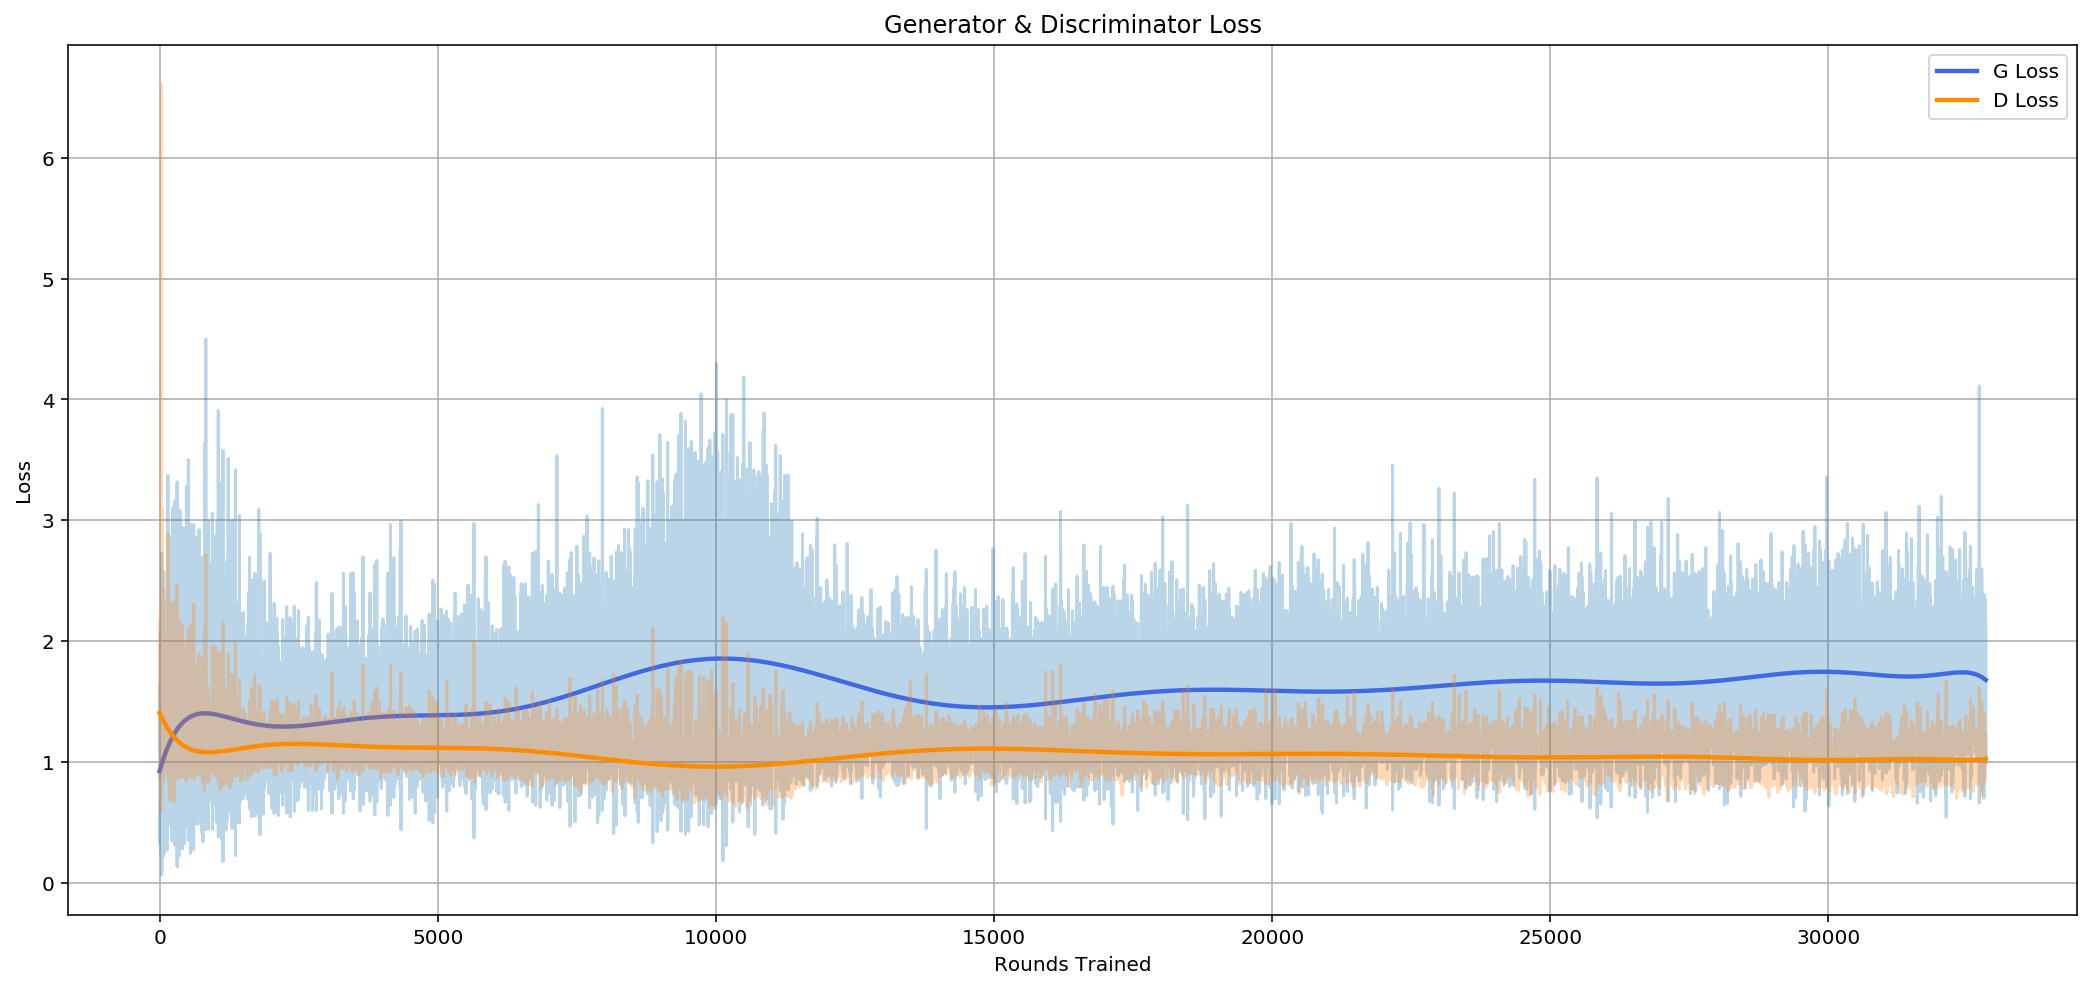

In [17]:
plt.figure(figsize=(18, 8))

plt.plot(G_loss, alpha=0.3)

x = np.arange(len(G_loss))
p = np.poly1d(np.polyfit(x, G_loss, 15))
xp = np.linspace(0, len(G_loss) - 1, 500)
plt.plot(xp, p(xp), color='royalblue', ls='-',
         lw=2.2, label='G Loss')

plt.plot(D_loss, alpha=0.3)

x = np.arange(len(D_loss))
p = np.poly1d(np.polyfit(x, D_loss, 15))
xp = np.linspace(0, len(D_loss) - 1, 500)
plt.plot(xp, p(xp), color='darkorange', ls='-',
         lw=2.2, label='D Loss')

plt.title('Generator & Discriminator Loss')
plt.xlabel('Rounds Trained'); plt.ylabel('Loss')
plt.grid(True); plt.legend();

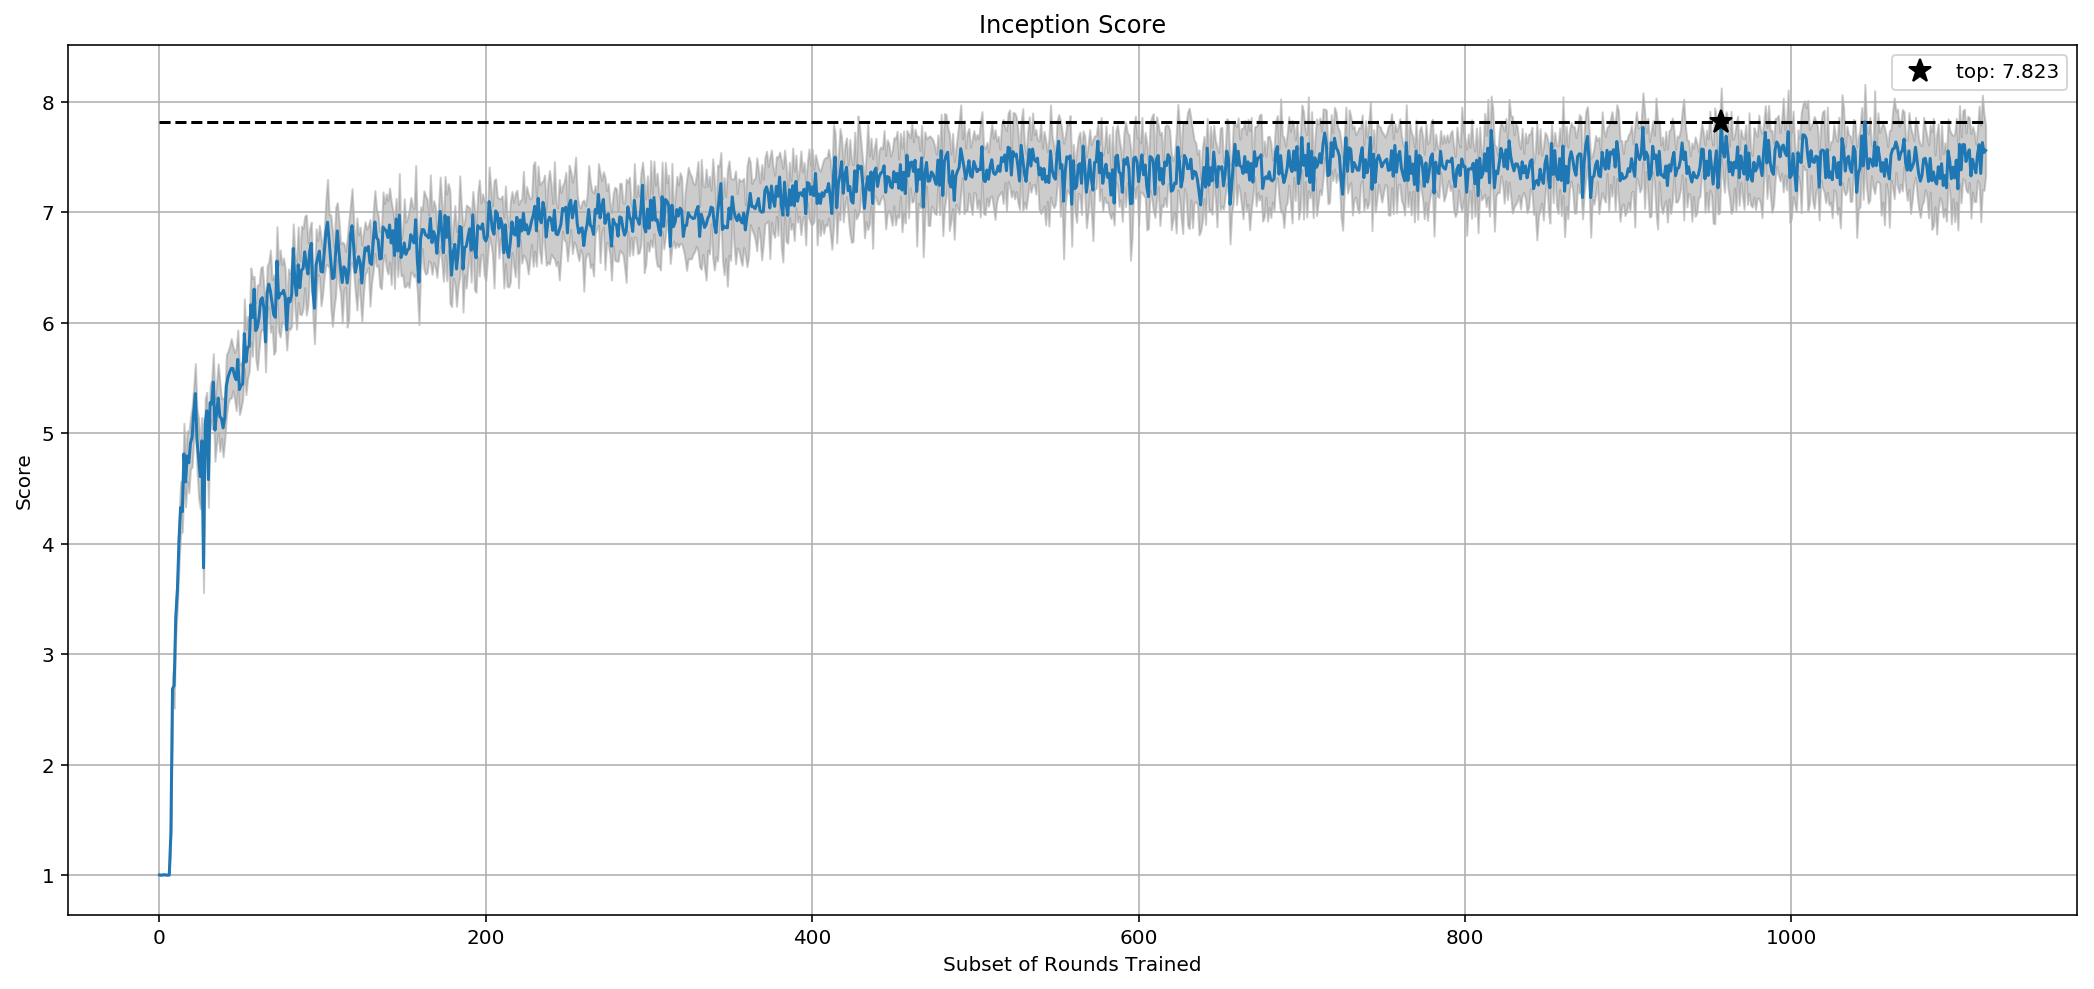

In [18]:
plt.figure(figsize=(18, 8))
inception = np.array(inception)

top_index = np.argmax(inception[:, 0])
top = inception[top_index][0]

plt.plot(inception[:, 0], '-')

plt.fill_between(np.arange(0, inception.shape[0], 1),
                 inception[:, 0] - inception[:, 1],inception[:, 0] + inception[:, 1],
                 color='gray', alpha=0.4)

plt.hlines(top, 0, inception.shape[0] - 1, linestyle='dashed')
plt.plot(top_index, top, 'k*', markersize=12, label='top: {0:.3f}'.format(top))

plt.xlabel('Subset of Rounds Trained'); plt.ylabel('Score')
plt.grid(True); plt.title('Inception Score'); plt.legend(loc=0);

In [19]:
def create_animation(tracked):
    fig = plt.figure(figsize=(18, 4));

    n_subplots = tracked.shape[1]
    axs = []
    for i in range(n_subplots):
        axs.append(fig.add_subplot(1, n_subplots, i + 1))
        
    ims = []
    for i, vector in enumerate(tracked):
        images = []
        for j, v in enumerate(vector):
            tmp = vectors_to_images(v).cpu().numpy()
            images.append(axs[j].imshow(-tmp.reshape((28, 28)), interpolation='nearest',
                                        cmap='gray', animated=True))
            axs[j].axis('off')
        ims.append(images)

    plt.close(fig);
    ani = animation.ArtistAnimation(fig, ims, interval=75, blit=True,
                                    repeat_delay=1500)
    return ani

ani = create_animation(tracked)
ani

# Conclusion  

## References

In [21]:
import io
from nbformat import current
import glob

nbfile = glob.glob('gan-project.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
    
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
    
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
        
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file gan-project.ipynb is 2984
